<a href="https://colab.research.google.com/github/Ayushsrinivas7/LLM_LEARNINGS/blob/main/PROJECT_INSTRUCTION_FINETUNNED_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

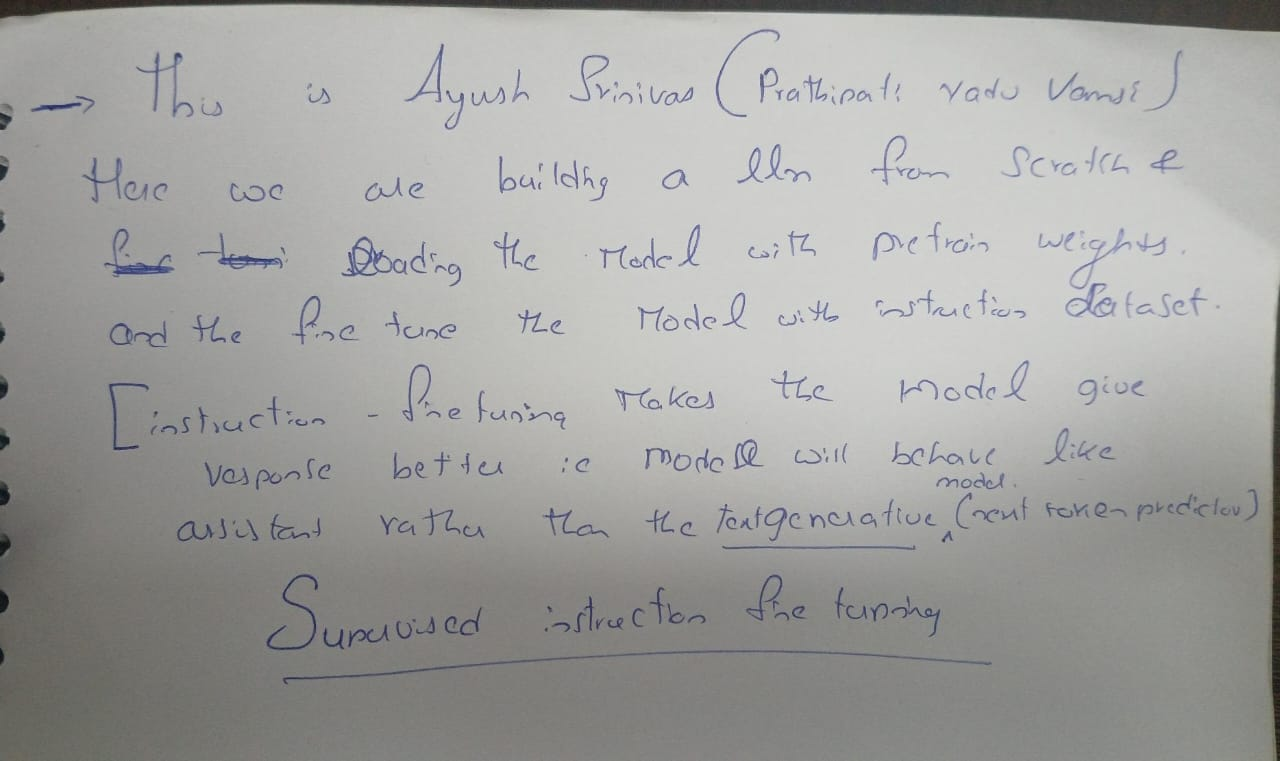

# Steps that we are going to follow

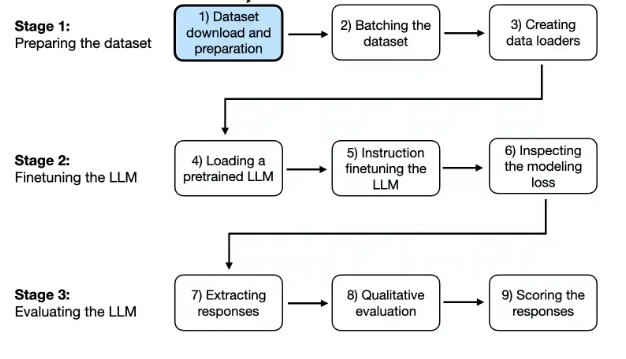

# GENERALLY WHEN EVER THE LINK OF DATA is given then we will use the urllib and will open the data .
lets define a function to load the data .

In [4]:
!pip install tiktoken datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux"

In [5]:
from torch.utils.data import Dataset , DataLoader
import torch

In [6]:
import json
import os
import urllib

def download_and_load_file(file_path , url ):

  if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response :
      text_data = response.read().decode("utf-8")
    with open(file_path , "w" , encoding = "utf-8" ) as file :
      file.write(text_data)

  with open(file_path , 'r' , encoding = "utf-8" ) as file :
    data = json.load(file)
  # json.load will make the json data to python object
  return data



file_path = 'instruction-data.json'
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)
data = download_and_load_file(file_path , url )
print("Number of entries:" , len(data))


Number of entries: 1100


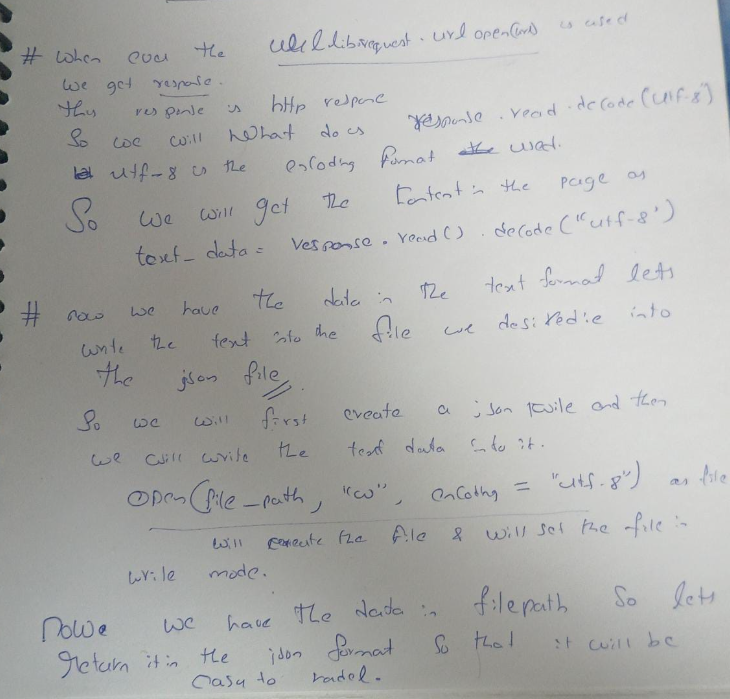

In [7]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [8]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


In [9]:
!pip install -qU datasets

Instruction finetuning is often referred to as "supervised instruction finetuning" because it involves training a model on a dataset where the input-output pairs are explicitly provided
There are different ways to format the entries as inputs to the LLM; the figure below illustrates two example formats that were used for training the Alpaca (https://crfm.stanford.edu/2023/03/13/alpaca.html) and Phi-3 (https://arxiv.org/abs/2404.14219) LLMs, respectively

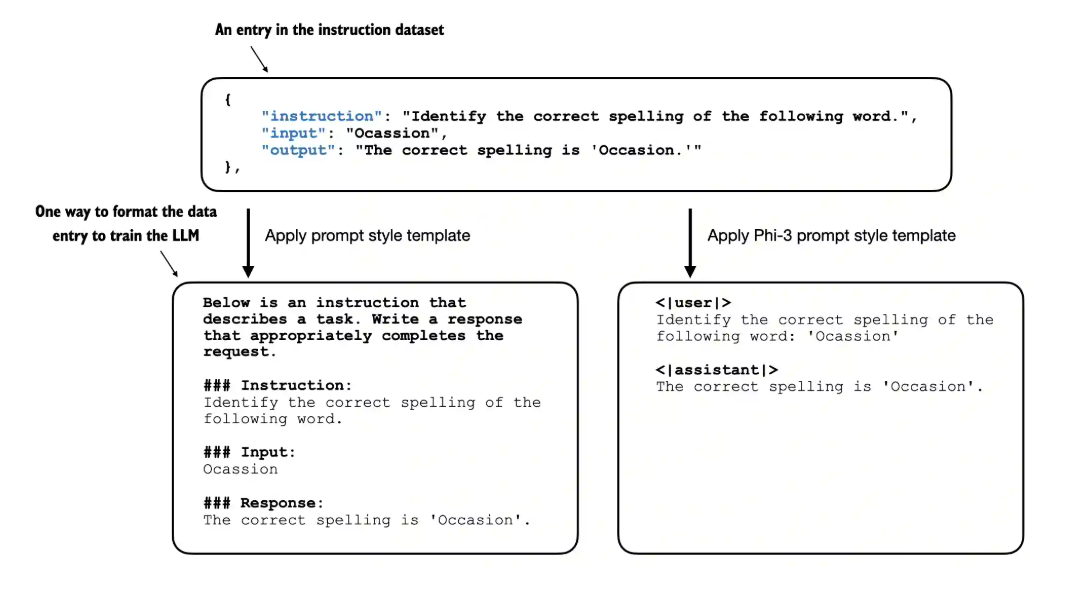

we use Alpaca-style prompt formatting, which was the original prompt template for instruction finetuning
Below, we format the input that we will pass as input to the LLM

In [10]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [11]:

model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [12]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [13]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## STEP 2: ORGANIZING DATA INTO TRAINING BATCHES

if we want to create a data loader we know we have to do is just create a dataset class and send this data set class to dataloder

lets create  collate function is responsible for taking a list of individual data samples and merging them into a single batch that can be processed efficiently by the model during training.

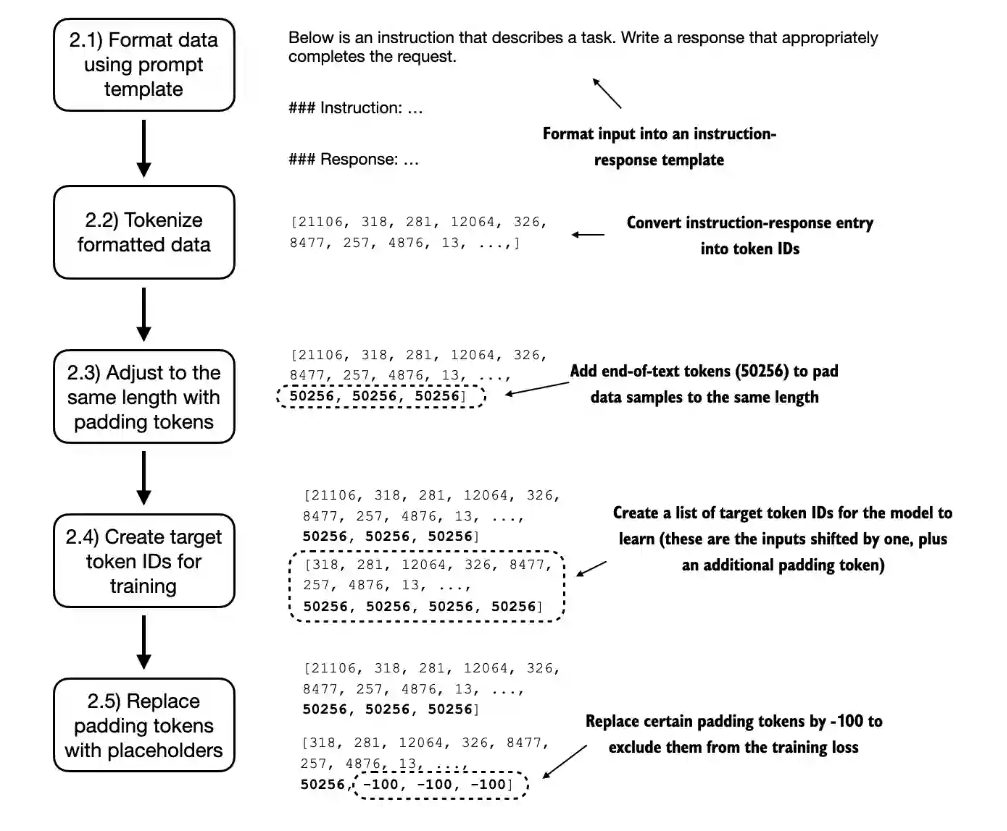

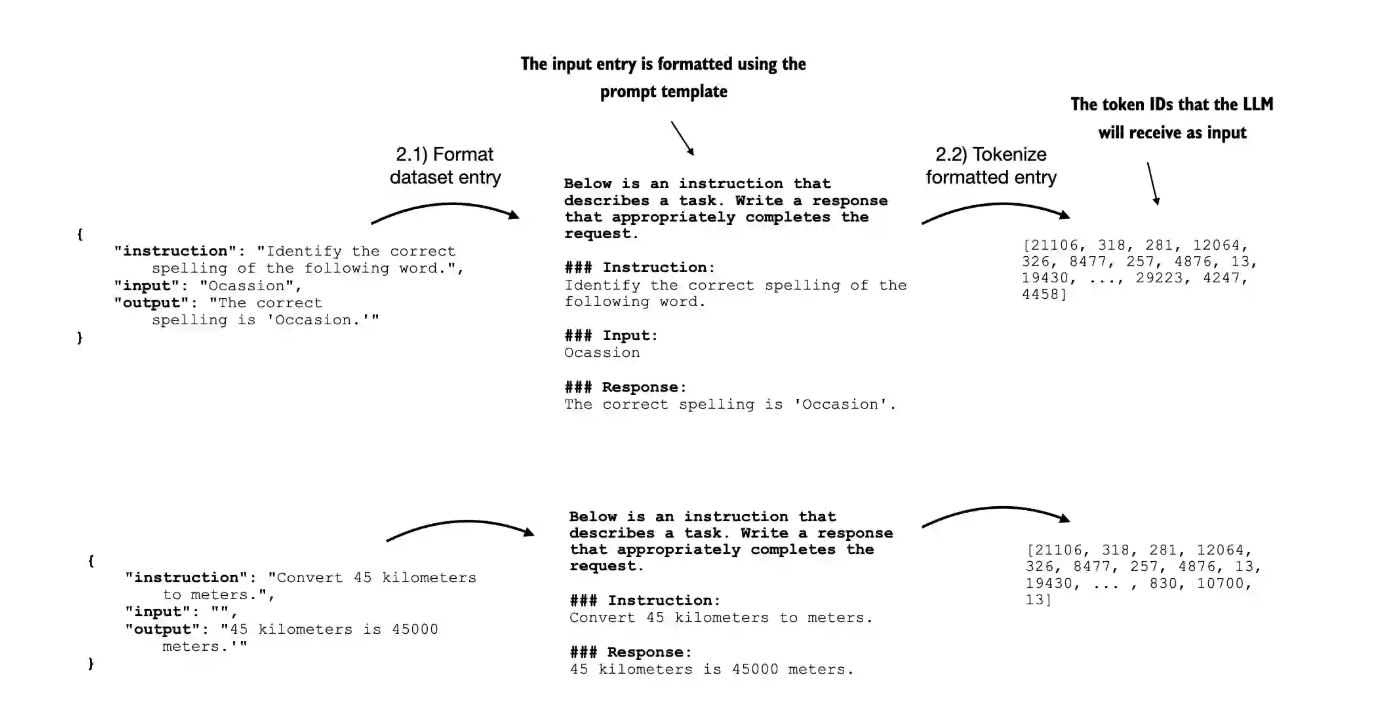

# Lets build the dataset class
1) __init__ 2) __len__ 3) __getitem__

In [14]:
from torch.utils.data import Dataset , DataLoader

In [15]:
class InstructionDataset(Dataset):

  def __init__(self , data , tokenizer):
    self.data = data

    self.encoded_text = []
    for ele in data:
      instruction_plus_input = format_input(ele)
      response_text =  f"\n\n### Response:\n{ele['output']}"
      full_text = instruction_plus_input + response_text
      self.encoded_text.append(
          tokenizer.encode(full_text)
      )

  def __getitem__(self , index ):
      return self.encoded_text[index]

  def __len__(self):
      return len(self.data)



we use the <|endoftext|> token as a padding token

In [16]:

import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


we padded all examples in a dataset to the same length
Here, we take a more sophisticated approach and develop a custom "collate" function that we can pass to the data loader
This custom collate function pads the training examples in each batch to have the same length (but different batches can have different lengths)

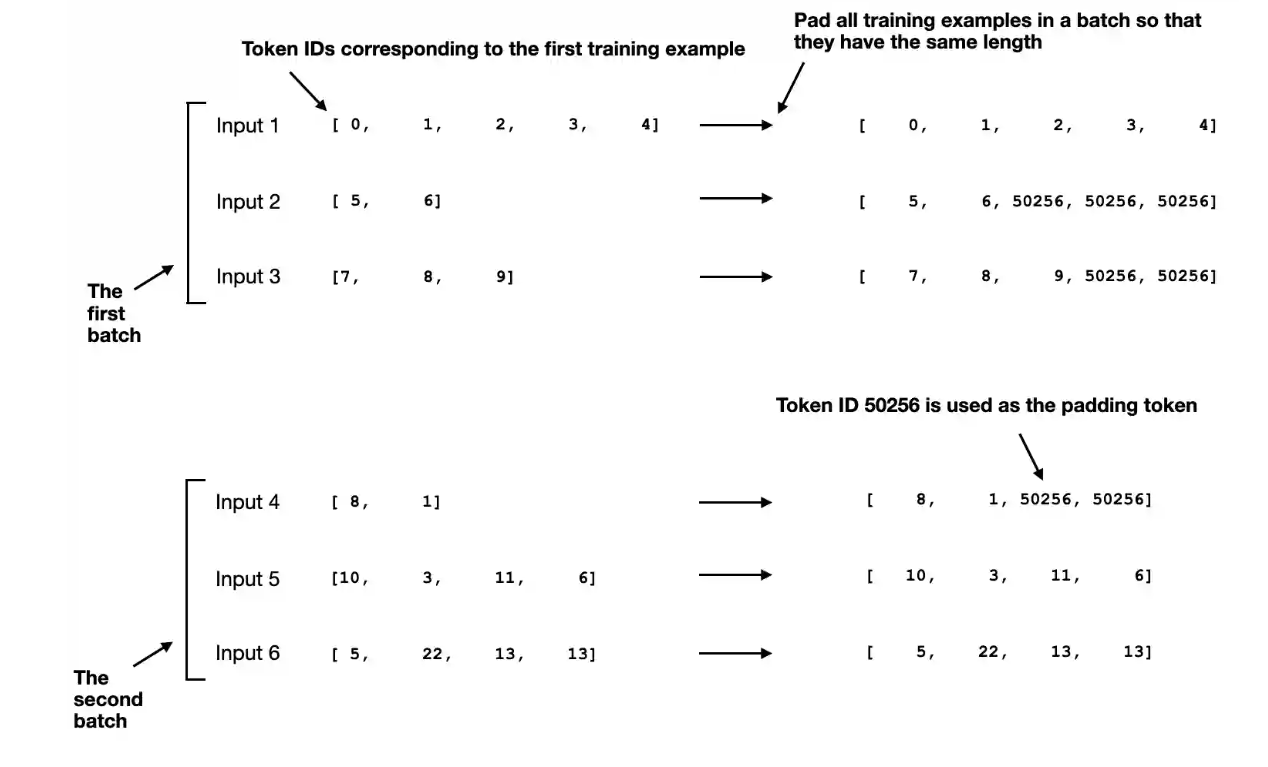

#note : normally what we do is we will go to all the data ie all_encoded_texts then we will check the max length and then we will make all the data equal to the maxLenth by adding 50256 .
# but now what we will do is we will send individual batches and check max of the datch and will make the all the texts in the batch equal to max length of batxh

In [17]:
def custom_collate_draft_1(batch , pad_token_id = 50256 , device = "cpu"):

  # find the logest sequence in the batch
  # and increase the max length by +1 , which will add one extra
  # padding token below
  batch_max_length = max(len(item) +1 for item in batch )
  # see here batch_max_length is max length +1 this is because
  # we want to add 50256 at the end of all the inputs
  # so that now evey input becomes max batch len + 1
  # -> we are doing this trick for a reason
  # -> reason is input is ( 0 to batch_max_length-1) and target is (1 to batch_max_length)

  inputs_lst = []
  for item in batch :
    new_item = item.copy()
    #Add on <|endoftext|> until present len is equal to batch_max_length
    padded = (
        new_item + [pad_token_id]*(batch_max_length - len(new_item))
    )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
    inputs = torch.tensor(padded[:-1])
    inputs_lst.append(inputs)

  inputs_tensor = torch.stack(inputs_lst).to(device)
  return inputs_tensor


In [18]:
import torch
torch.manual_seed(123)
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


Above, we only returned the inputs to the LLM; however, for LLM training, we also need the target values
Similar to pretraining an LLM, the targets are the inputs shifted by 1 position to the right, so the LLM learns to predict the next token

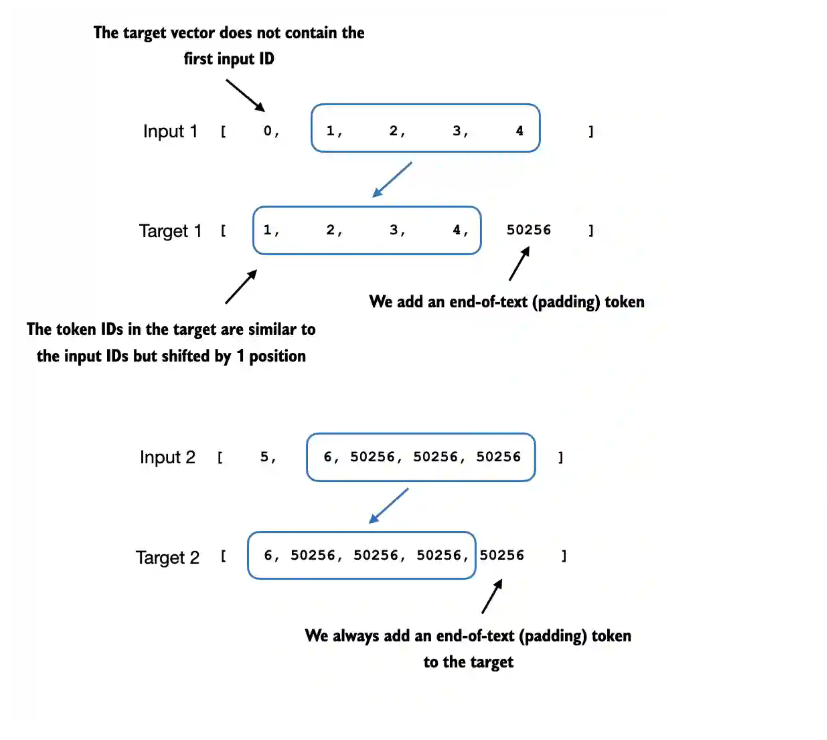

In [19]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [20]:
inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


we introduce an ignore_index value to replace all padding token IDs with a new value; the purpose of this ignore_index is that we can ignore padding values in the loss function

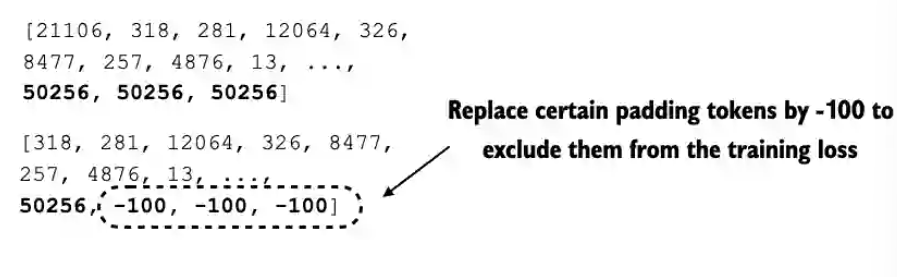

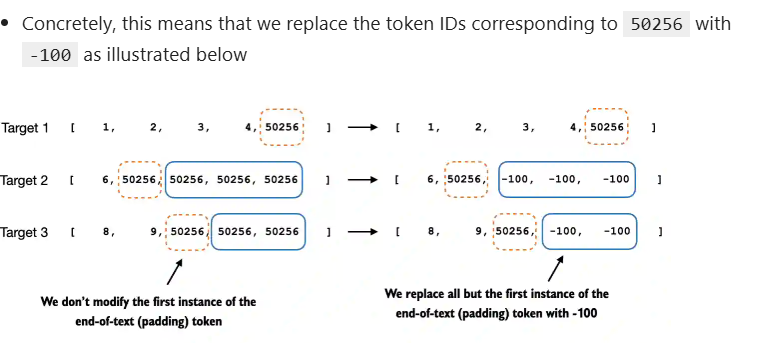

we also introduce the allowed_max_length in case we want to limit the length of the samples; this will be useful if you plan to work with your own datasets that are longer than the 1024 token context size supported by the GPT-2 model

#we know loss in the llm is caluclated as :
#(batch , seqlen , vocabsize) is logits and target is
#seqlen array which has the index
#when we write the fucntion torch.corss enropy(logits[: , -1 , : ] , target ) it will take
#the average of crossentorpy of all the token in sequence .
#but we know that we dont want to to incude the extra tokens which we wrote ie padded 50256
#so if we give index -100 in that place so that torch will not incude the probabailites related to it .
#ie if we 30 tokens and out of that last 6 in the target are -100 then we only caluclate the loss for the 24 tokens so thats why for the targets we will keep -1 for the unwanted tokens.


In [21]:
def custom_collate_fn( batch , pad_token_id = 50256 , ignore_index = -100  , allowed_max_length = None  , device = "cpu"):
  batch_max_length = max(len(item) +1 for item in batch )
  inputs_lst , targets_lst = [] , []

  for item in batch :
    new_item = item.copy()
    padded = (
        new_item + [pad_token_id] * (batch_max_length - len(new_item))
    )
    inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
    targets = torch.tensor(padded[1:])   # Shift +1 to the right for targets

    # as dicussed above lets replace all the extra unwanted with -100
    mask = targets == pad_token_id
    indices = torch.nonzero(mask).squeeze()
    if indices.numel() > 1:
      # we will replace all the extra 50256 with -100
      targets[indices[1:]] = ignore_index

    if allowed_max_length is not None:
      inputs = inputs[:allowed_max_length]
      targets = targets[:allowed_max_length]

    inputs_lst.append(inputs)
    targets_lst.append(targets)


  # Convert list of inputs and targets to tensors and transfer to target device
  inputs_tensor = torch.stack(inputs_lst).to(device)
  targets_tensor = torch.stack(targets_lst).to(device)

  return inputs_tensor, targets_tensor




In [22]:

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


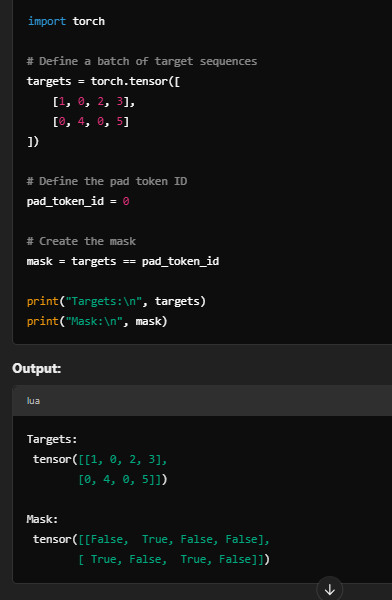

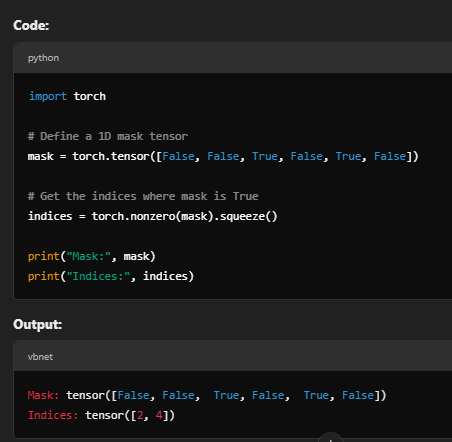

Let's see what this replacement by -100 accomplishes
For illustration purposes, let's assume we have a small classification task with 2 class labels, 0 and 1,.
If we have the following logits values (outputs of the last layer of the model), we calculate the following loss


In [23]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],  # 1st training example
     [-0.5, 1.5]]  # 2nd training example
)
targets_1 = torch.tensor([0, 1])


loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [24]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]  # New 3rd training example
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


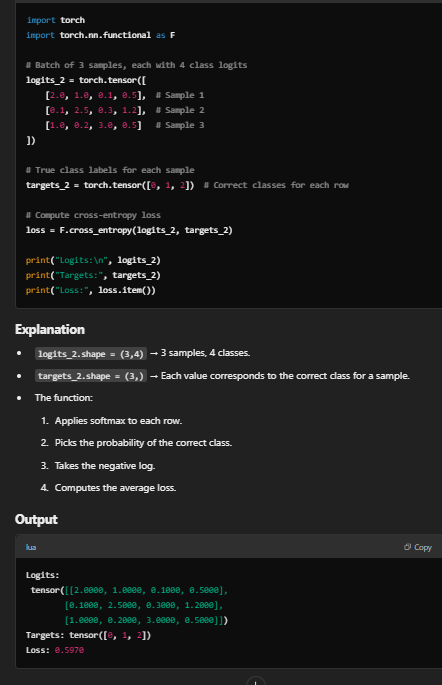

#Let's see what happens if we replace the class label of one of the examples with -100

In [25]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)


tensor(1.1269)
loss_1 == loss_3: tensor(True)


oss_1 == loss_3: tensor(True)

#this is because the third index is ignored As we can see, the resulting loss on these 3 training examples is the same as the loss we calculated from the 2 training examples, which means that the cross-entropy loss function ignored the training example with the -100 label
#By default, PyTorch has the cross_entropy(..., ignore_index=-100) setting to ignore examples corresponding to the label -100
#Using this -100 ignore_index, we can ignore the additional end-of-text (padding) tokens in the batches that we used to pad the training examples to equal length
#However, we don't want to ignore the first instance of the end-of-text (padding) token (50256) because it can help signal to the LLM when the response is complete
#In practice, it is also common to mask out the target token IDs that correspond to the instruction, as illustrated in the figure below

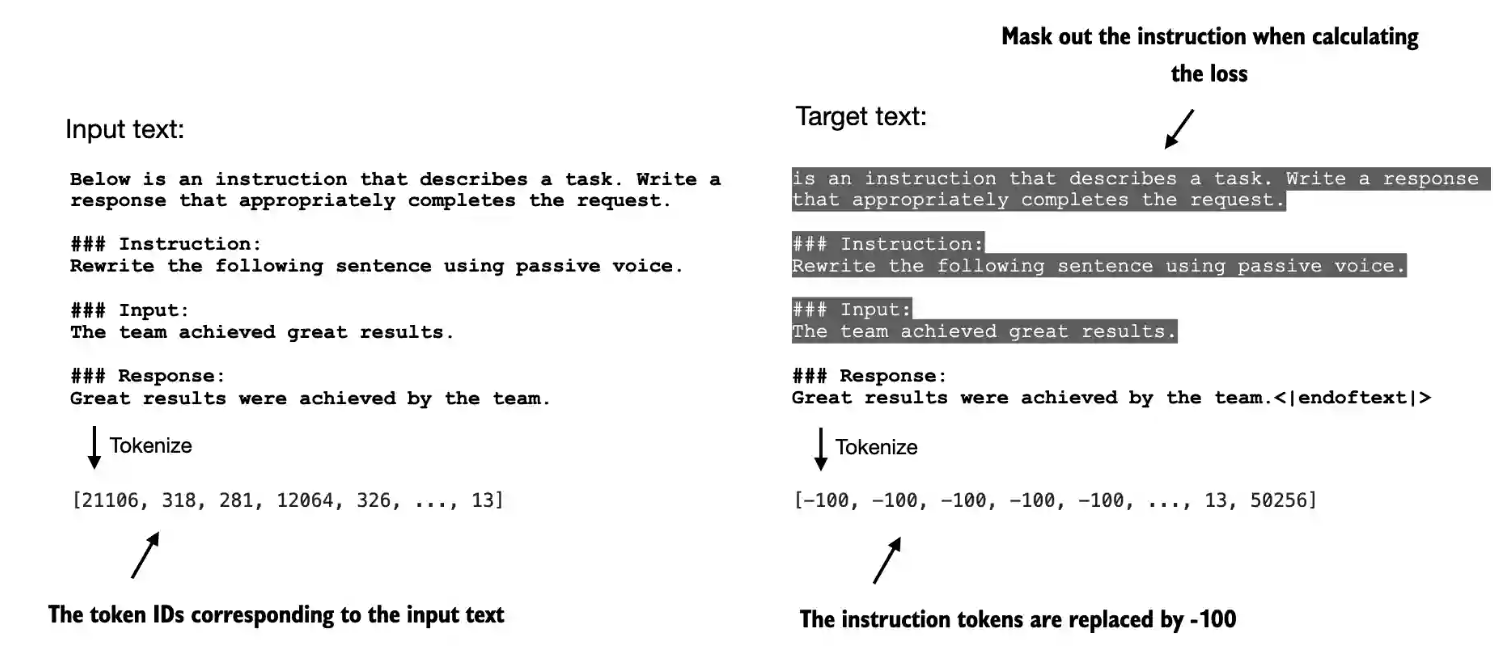

In [26]:
data

[{'instruction': 'Evaluate the following phrase by transforming it into the spelling given.',
  'input': 'freind --> friend',
  'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'},
 {'instruction': 'Edit the following sentence for grammar.',
  'input': 'He go to the park every day.',
  'output': 'He goes to the park every day.'},
 {'instruction': 'Convert 45 kilometers to meters.',
  'input': '',
  'output': '45 kilometers is 45000 meters.'},
 {'instruction': "Rewrite this sentence to start with 'Although': Despite the rain, they went for a walk.",
  'input': '',
  'output': 'Although it was raining, they went for a walk.'},
 {'instruction': 'What are the first 10 square numbers?',
  'input': '',
  'output': '1, 4, 9, 16, 25, 36, 49, 64, 81, 100.'},
 {'instruction': 'Suggest a more formal synonym for "happy."',
  'input': '',
  'output': 'A more formal synonym for "happy" is "content."'},
 {'instruction': 'Translate the following sente

##  CREATING DATALOADERS FOR AN INSTRUCTION DATASET

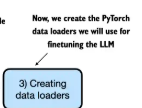

Another additional detail of the previous custom_collate_fn function is that we now directly move the data to the target device (e.g., GPU) instead of doing it in the main training loop, which improves efficiency because it can be carried out as a background process when we use the custom_collate_fn as part of the data loader
Using the partial function from Python's functools standard library, we create a new function with the device argument of the original function pre-filled

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else  "cpu")
print("Device" , device )

Device cuda


In [28]:
from functools import partial

customized_collate_fn = partial(
    custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

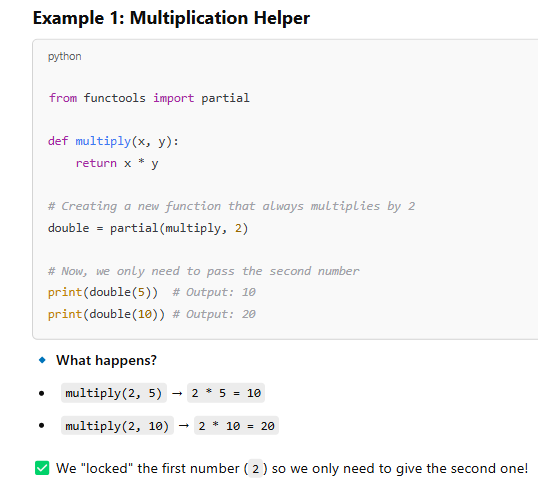

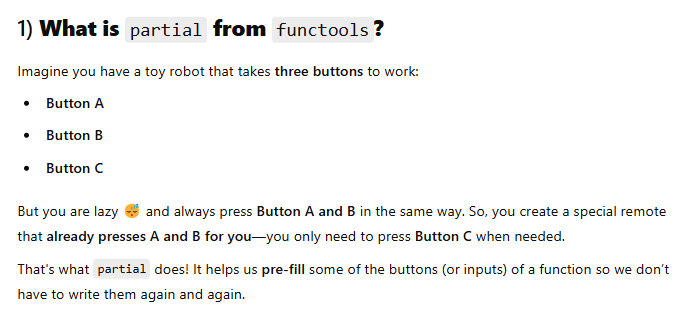

## Remeber that data loader genrally has the inbuilt collate function ie the function that takes the dataset_class and creates the input target pair and bakes the batches . but here we are using the custom function for the collate ie creating the input target paris and their batching

In [29]:
from torch.utils.data import DataLoader
num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_dataset = InstructionDataset(train_data , tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    collate_fn = customized_collate_fn ,
    shuffle = True,
    drop_last = True ,
    num_workers = num_workers
)



In [30]:
val_dataset = InstructionDataset(val_data , tokenizer)
val_loader = DataLoader(
    val_dataset ,
    batch_size = batch_size,
    collate_fn = customized_collate_fn,
    shuffle = True,
    drop_last = True ,
    num_workers = num_workers
)

In [31]:
test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [32]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

## each abtch is of different size as cust collate will make all elemnts in the batch equal my taking the max of that particualr batch

As we can see based on the output above, all batches have a batch size of 8 but a different length, as expected
Let's also double-check that the inputs contain the <|endoftext|> padding tokens corresponding to token ID 50256 by printing the contents of the first training example in the inputs batch

In [33]:
print(inputs[0])

tensor([21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
          257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,   198,
        21017, 46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,
          985,   576,    13,   198,   198, 21017, 23412,    25,   198,   464,
         5156,   318,   845, 13779,    13,   198,   198, 21017, 18261,    25,
          198,   464,  5156,   318,   355, 13779,   355,   257,  4936,    13,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='cuda:0')


In [34]:
print(targets[0])

tensor([  318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,   257,
         2882,   326, 20431, 32543,   262,  2581,    13,   198,   198, 21017,
        46486,    25,   198, 30003,  6525,   262,  6827,  1262,   257,   985,
          576,    13,   198,   198, 21017, 23412,    25,   198,   464,  5156,
          318,   845, 13779,    13,   198,   198, 21017, 18261,    25,   198,
          464,  5156,   318,   355, 13779,   355,   257,  4936,    13, 50256,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='cuda:0')


## 4: LOADING A PRETRAINED LLM

Before beginning instruction finetuning, we first load a pretrained GPT model,

Instead of using the smallest 124 million parameter model as before, we load the medium-sized model with 355 million parameters.

The reason for this choice is that the 124 million parameter model is too limited in capacity to achieve qualitatively satisfactory results via instruction finetuning.

In [35]:
from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 26.2kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:02<00:00, 512kiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 38.7kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [07:52<00:00, 3.01MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 6.11MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:01<00:00, 511kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 322kiB/s]


In [36]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [37]:
from previous_chapters import (
    generate,
    text_to_token_ids,
    token_ids_to_text
)

token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [38]:
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


# we have seen before that we have made the text or prompt  in a way that we added the input text + output text .
# so this gives the convinence of estimating the length of the input and then remove the input length tokens and then we can display the output

but remeber the output is always unexpected as the gpt is blackbox

In [39]:
response_text = (
    generated_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


This code snippet removes the input text from the beginning of the generated_text, leaving us with only the model's generated response. The strip() function is then applied to remove any leading or trailing whitespace characters. The output is as follows:

## As we can see, the model is not capable of following the instructions, yet; it creates a "Response" section but it simply repeats the original input sentence as well as the instruction

## FINETUNING THE LLM ON INSTRUCTION DATA

we know fine tunning the llm is all about the data - model - loss function <br>
all we do is just try to decrease the loss fucntion value

so lets define the loss fucntion .... and other tools required to clauclate the loss  

In [40]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


In [41]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


In [42]:
from previous_chapters import (
    calc_loss_loader,
    train_model_simple
)

In [43]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.825909471511841
Validation loss: 3.7975183010101317


In [44]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.621
Ep 1 (Step 000005): Train loss 1.083, Val loss 1.107
Ep 1 (Step 000010): Train loss 0.916, Val loss 0.930
Ep 1 (Step 000015): Train loss 0.829, Val loss 0.926
Ep 1 (Step 000020): Train loss 0.772, Val loss 0.829
Ep 1 (Step 000025): Train loss 0.753, Val loss 0.893
Ep 1 (Step 000030): Train loss 0.709, Val loss 0.805
Ep 1 (Step 000035): Train loss 0.751, Val loss 0.838
Ep 1 (Step 000040): Train loss 0.667, Val loss 0.798
Ep 1 (Step 000045): Train loss 0.765, Val loss 0.729
Ep 1 (Step 000050): Train loss 0.696, Val loss 0.743
Ep 1 (Step 000055): Train loss 0.604, Val loss 0.744
Ep 1 (Step 000060): Train loss 0.655, Val loss 0.746
Ep 1 (Step 000065): Train loss 0.662, Val loss 0.718
Ep 1 (Step 000070): Train loss 0.541, Val loss 0.711
Ep 1 (Step 000075): Train loss 0.558, Val loss 0.735
Ep 1 (Step 000080): Train loss 0.668, Val loss 0.737
Ep 1 (Step 000085): Train loss 0.576, Val loss 0.724
Ep 1 (Step 000090): Train loss 0.533, Val loss

In [44]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

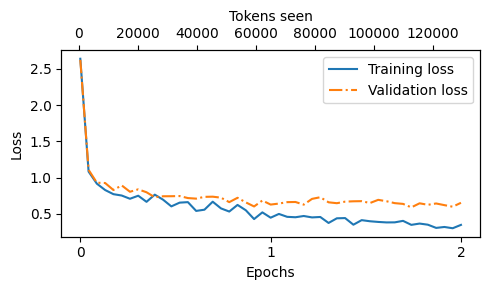

In [45]:
from previous_chapters import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [48]:
torch.manual_seed(123)

for entry in test_data[:4]:
  input_text = format_input(entry)

  token_ids = generate(
      model = model ,
      idx = text_to_token_ids( input_text , tokenizer).to(device),
      max_new_tokens = 256 ,
      context_size = BASE_CONFIG["context_length"],
      eos_id = 50256
  )

  generated_text = token_ids_to_text(token_ids , tokenizer )
  response_text = (
      generated_text[len(input_text):].replace("### Response : " , "").strip()

  )
  print(input_text)
  print(f"\nCorrect response:\n>> {entry['output']}")
  print(f"\nModel response:\n>> {response_text.strip()}")
  print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> ### Response:
The car is as fast as a cheetah.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> ### Response:
The type of cloud associated with thunderstorms is a cumulus.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> ### Re

#  we can see based on the test set instructions, given responses, and the model's responses, the model performs relatively well

# The answers to the first and last instructions are clearly correct



The second answer is close; the model answers with "cumulus cloud" instead of "cumulonimbus" (however, note that cumulus clouds can develop into cumulonimbus clouds, which are capable of producing thunderstorms)

Most importantly, we can see that model evaluation is not as straightforward as in the previous Project, where we just had to calculate the percentage of correct spam/non-spam class labels to obtain the classification accuracy

## short-answer and multiple choice benchmarks such as MMLU ("Measuring Massive Multitask Language Understanding", https://arxiv.org/abs/2009.03300), which test the knowledge of a model
## human preference comparison to other LLMs, such as LMSYS chatbot arena (https://arena.lmsys.org)
## automated conversational benchmarks, where another LLM like GPT-4 is used to evaluate the responses, such as AlpacaEval (https://tatsu-lab.github.io/alpaca_eval/)

## LLM EVALUATION

what tqdm will tell is display a box kind of thing for showing the progress

In [49]:
from tqdm import tqdm
for i , entry in tqdm(enumerate(test_data) , total = len(test_data)):
  input_text = format_input(entry)

  token_ids = generate(
      model = model ,
      idx = text_to_token_ids(input_text , tokenizer).to(device),
      max_new_tokens = 256 ,
      context_size = BASE_CONFIG["context_length"],
      eos_id=50256
  )
  generated_text = token_ids_to_text(token_ids, tokenizer)
  response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

  test_data[i]["model_response"] = response_text



100%|██████████| 110/110 [01:24<00:00,  1.31it/s]


In [51]:
with open("instruction-data-with-response.json" , "w") as file :
  json.dump(test_data , file , indent = 4)


In [52]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a cheetah.'}


## so now see we above we have we have "instruction-data-with-response.json" where we have the data

Let's double-check one of the entries to see whether the responses have been added to the test_data dictionary correctly

In [54]:

import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


## FOR EVALUATING WHAT WE ARE GOING TO DO IS IS TAKE A BIG MODEL AND AKSING IT THAT HEY I HAVE A MODEL A IT GENERETED THE REPONSE FOR THIS PROMPT ie WE GIVE PROMPT AND RESPONSE OF MODEL TO THE BIG LLM AND THEN WE WILL AKS IT TO GIVE SCORE .

In [55]:
!pip install --quiet langchain langchain-core  langchain-community langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.2/413.2 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.2/150.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.4 MB/s eta 0:00:00


In [56]:
!pip install colab-xterm
%load_ext colabxterm
%xterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 9.8 MB/s eta 0:00:00


Launching Xterm...

<IPython.core.display.Javascript object>

In [57]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_community langchain_core tavily-python wikipedia
%pip install -qU langchain-ollama

In [58]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.1",
    temperature=0.9,
)

In [61]:
response = llm.invoke("Write about AI in Education under 50 words")

In [63]:
response.content

"Artificial Intelligence (AI) is transforming education by personalizing learning, automating grading, and providing real-time feedback. Adaptive learning platforms use AI to tailor lessons to individual students' needs, abilities, and learning styles, improving academic outcomes and student engagement."

so using the ollama we created the llm.